# Startup

## 0. Общая информация

По легенде я работаю в стартапе, который продаёт продукты питания. Мне нужно разобраться, как ведут себя пользователи мобильного приложения. 

*Каждая запись в логе — это действие пользователя, или событие.*

- _EventName_ — название события;
- _DeviceIDHash_ — уникальный идентификатор пользователя;
- _EventTimestamp_ — время события;
- _ExpId_ — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

## 1. Чтение данных

In [1]:
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px

from scipy import stats as st # модуль для z-теста пропорций
import numpy as np
import math as mth

from datetime import datetime as dt

In [2]:
# в атрибут parse_dates передаем колоники со стандартизированными данными и они распознаются как дата
try:
    logs = pd.read_csv('/datasets/logs_exp.csv', sep='\t',parse_dates=['EventTimestamp']) # отделяем названия стобцов друг от друга
except:
    logs = pd.read_csv('logs_exp.csv', sep='\t')
print(logs)

                      EventName         DeviceIDHash  EventTimestamp  ExpId
0              MainScreenAppear  4575588528974610257      1564029816    246
1              MainScreenAppear  7416695313311560658      1564053102    246
2       PaymentScreenSuccessful  3518123091307005509      1564054127    248
3              CartScreenAppear  3518123091307005509      1564054127    248
4       PaymentScreenSuccessful  6217807653094995999      1564055322    248
...                         ...                  ...             ...    ...
244121         MainScreenAppear  4599628364049201812      1565212345    247
244122         MainScreenAppear  5849806612437486590      1565212439    246
244123         MainScreenAppear  5746969938801999050      1565212483    246
244124         MainScreenAppear  5746969938801999050      1565212498    246
244125       OffersScreenAppear  5746969938801999050      1565212517    246

[244126 rows x 4 columns]


## 2. Изучение и подготовка данных

### 2.1. Описание данных

Каждая запись в логе — это действие пользователя, или событие.

- _EventName_ — название события;
- _DeviceIDHash_ — уникальный идентификатор пользователя;
- _EventTimestamp_ — время события;
- _ExpId_ — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

### 2.2. Меняем названия столбцов

In [3]:
logs.columns = logs.columns.str.lower().str.strip().str.replace(' ', '_')
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   eventname       244126 non-null  object
 1   deviceidhash    244126 non-null  int64 
 2   eventtimestamp  244126 non-null  int64 
 3   expid           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


### 2.3. Проверяем пропуски и типы данных

In [4]:
logs.isna().sum()# подсчёт пропусков

eventname         0
deviceidhash      0
eventtimestamp    0
expid             0
dtype: int64

In [5]:
display(logs.head()), logs.info()

,eventname,deviceidhash,eventtimestamp,expid
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   eventname       244126 non-null  object
 1   deviceidhash    244126 non-null  int64 
 2   eventtimestamp  244126 non-null  int64 
 3   expid           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


(None, None)

In [6]:
print('Количество дубликатов:', logs.duplicated().sum())

Количество дубликатов: 413


In [7]:
logs =  logs.drop_duplicates().reset_index(drop=True)# удаление явных дубликатов (с удалением старых индексов и формированием новых)
display(logs.head()), logs.info()
print('Количество дубликатов:', logs.duplicated().sum()) # проверка

,eventname,deviceidhash,eventtimestamp,expid
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   eventname       243713 non-null  object
 1   deviceidhash    243713 non-null  int64 
 2   eventtimestamp  243713 non-null  int64 
 3   expid           243713 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.4+ MB
Количество дубликатов: 0


**Выводы**:
- eventtimestamp имеет тип int64, но так как это дата, то нужно перевети в формат datetime, чтобы добавить столбец даты и времени, а так же отдельный столбец дат.
- Пропусков нет, дубликаты мы удалили.

### 2.4. Добавление столбца даты и времени, и отдельный столбец дат.

In [8]:
logs['eventtimestamp'] = pd.to_datetime(logs['eventtimestamp'], unit='s')
logs['eventtimestamp']

0        2019-07-25 04:43:36
1        2019-07-25 11:11:42
2        2019-07-25 11:28:47
3        2019-07-25 11:28:47
4        2019-07-25 11:48:42
                 ...        
243708   2019-08-07 21:12:25
243709   2019-08-07 21:13:59
243710   2019-08-07 21:14:43
243711   2019-08-07 21:14:58
243712   2019-08-07 21:15:17
Name: eventtimestamp, Length: 243713, dtype: datetime64[ns]

In [9]:
logs.head() # проверка

,eventname,deviceidhash,eventtimestamp,expid
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248


In [10]:
# Добавление столбца даты и времени (datetime)
logs['datetime'] = pd.to_datetime(logs['eventtimestamp'], unit='s')
logs.head()

,eventname,deviceidhash,eventtimestamp,expid,datetime
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25 04:43:36
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25 11:11:42
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25 11:28:47
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25 11:28:47
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25 11:48:42


In [11]:
# Добавление столбца даты (date)
logs['date'] = logs['eventtimestamp'].dt.date
logs['date'] = pd.to_datetime(logs['date']) # преобразование в datetime
logs.head()
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   eventname       243713 non-null  object        
 1   deviceidhash    243713 non-null  int64         
 2   eventtimestamp  243713 non-null  datetime64[ns]
 3   expid           243713 non-null  int64         
 4   datetime        243713 non-null  datetime64[ns]
 5   date            243713 non-null  datetime64[ns]
dtypes: datetime64[ns](3), int64(2), object(1)
memory usage: 11.2+ MB


**Выводы**

- Дубликаты удалили. На памяти это не сильно отразилось.

- Добавили столбцы даты и времени (datetime) и отдельно даты (date). При этом объем используемой памяти увеличился с 7.4+ MB до 11.2+ MB, что в общем-то логично.

In [12]:
# проверяем не переместились ли пользователи из одной группы в другую. 
# Удаляем индексы deviceidhash. Смотрим группу 246 и 247, очищаем
duplicates = logs.loc[logs['expid'] == '246','deviceidhash'].isin(logs.loc[logs['expid'] == '247','deviceidhash'])
logs = logs.drop(duplicates[duplicates].index)
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   eventname       243713 non-null  object        
 1   deviceidhash    243713 non-null  int64         
 2   eventtimestamp  243713 non-null  datetime64[ns]
 3   expid           243713 non-null  int64         
 4   datetime        243713 non-null  datetime64[ns]
 5   date            243713 non-null  datetime64[ns]
dtypes: datetime64[ns](3), int64(2), object(1)
memory usage: 11.2+ MB


In [13]:
# Можно ещё так
users_246 = set(logs[logs['expid'] == 246]['deviceidhash'].unique())
users_247 = set(logs[logs['expid'] == 247]['deviceidhash'].unique())

# Нахождение пересечения пользователей
common_users = users_246.intersection(users_247)

if len(common_users) == 0:
    print('Пересечения пользователей в разных группах не найдено')
else:
    print(f'Найдено {len(common_users)} общих пользователей в разных группах')


Пересечения пользователей в разных группах не найдено


## 3. Изучение и проверка данных

- Сколько всего событий в логе?
- Сколько всего пользователей в логе?
- Сколько в среднем событий приходится на пользователя?
- Данными за какой период вы располагаете? Найдите максимальную и минимальную дату. Постройте гистограмму по дате и времени. Можно ли быть уверенным, что у вас одинаково полные данные за весь период? Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Определите, с какого момента данные полные и отбросьте более старые. Данными за какой период времени вы располагаете на самом деле?
- Много ли событий и пользователей вы потеряли, отбросив старые данные?
- Проверьте, что у вас есть пользователи из всех трёх экспериментальных групп.

### 3.1. Описание данных

Каждая запись в логе — это действие пользователя, или событие.

- _eventname_ — название события;
- _deviceidhash_ — уникальный идентификатор пользователя;
- _eventtimestamp_ — время события;
- _expid_ — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная;
- _datetime_ - дата в время событий;
- _date_ - дата события.

In [14]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   eventname       243713 non-null  object        
 1   deviceidhash    243713 non-null  int64         
 2   eventtimestamp  243713 non-null  datetime64[ns]
 3   expid           243713 non-null  int64         
 4   datetime        243713 non-null  datetime64[ns]
 5   date            243713 non-null  datetime64[ns]
dtypes: datetime64[ns](3), int64(2), object(1)
memory usage: 11.2+ MB


### 3.2. Количество событий в логе

In [15]:
logs.shape[0]

243713

### 3.3. Количество пользователей в логе

In [16]:
logs['deviceidhash'].nunique()

7551

### 3.4. Количество событий на одного пользователя в среднем.

In [17]:
events_per_user = logs.shape[0] / logs['deviceidhash'].nunique()
events_per_user

32.27559263673685

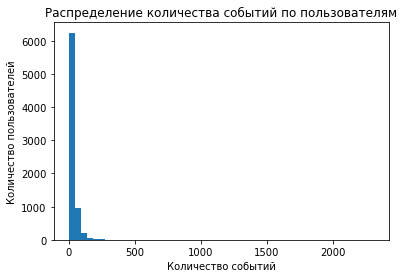

In [18]:
# Группировка по пользователям и подсчет количества событий
events_by_user = logs.groupby('deviceidhash', as_index=False).agg({'eventname': 'count'})

# Построение гистограммы
plt.hist(events_by_user['eventname'], bins=50)
plt.title('Распределение количества событий по пользователям')
plt.xlabel('Количество событий')
plt.ylabel('Количество пользователей')
plt.show()

In [55]:
events_by_user.median()

deviceidhash    4.688022e+18
eventname       2.000000e+01
dtype: float64

**Выводы**:
 - В логе 243713 событий.
 - Количество уникальных пользователей 7551
 - В среднем приходится 32.27559263673685 на одного пользователя.Не смотря на это, по гистограмме видны аномально большое количество пользователей, кто сделал явно меньше 32 событий. 
 - Гистограмма имеет большой хвост, что говорит о том, выбросы сильно влияют на среднее, значит в нашем случае медиана лучше характеризует поведение пользователей : это 2 события.

### 3.5. Максимальная и минимальная дата.

- Постройте гистограмму по дате и времени. Можно ли быть уверенным, что у вас одинаково полные данные за весь период? Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». 
- Определите, с какого момента данные полные и отбросьте более старые. Данными за какой период времени вы располагаете на самом деле?

In [20]:
print('Минимальная дата:', logs['date'].min())
print('Максимальная дата:', logs['date'].max())

Минимальная дата: 2019-07-25 00:00:00
Максимальная дата: 2019-08-07 00:00:00


 - Мы располагаем даннами с 25 июля 2019 года по 7 августа 2019 года

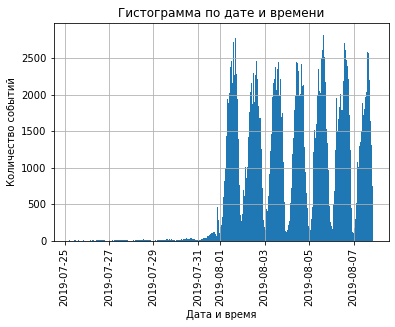

In [21]:
logs['datetime'].hist(bins=14*24)
plt.xlabel('Дата и время')
plt.ylabel('Количество событий')
plt.xticks(rotation = 90) # поворот надписей оси Х на 90 градусов
plt.title("Гистограмма по дате и времени")
plt.show()

**Выводы**:
- Нельзя сказать с уверенностю, что у нас одинаково полные данные за весь период. Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». 
- Судя по гистограмме, у нас есть полные данные с 1 по 8 августа включительно.
- Тест был запущен 1-го августа, а предыдущие события - это старые логи, которые "доехали" в выборку

### 3.6. Срез данных до 1 августа

In [56]:
# Установка определенной даты
cutoff_date = '2019-08-01'

# Создание нового датафрейма с данными, датированными после определенной даты
logs_filtered = logs[logs['datetime'] >= cutoff_date]

# Вывод первых строк нового датафрейма для проверки
logs_filtered.head()
logs_filtered['expid'].head(5) # проверка  пользов. эксперементальных групп

2826    246
2827    246
2828    246
2829    246
2830    247
Name: expid, dtype: int64

In [23]:
print('Минимальная дата:', logs_filtered['datetime'].min())
print('Максимальная дата:', logs_filtered['datetime'].max())

Минимальная дата: 2019-08-01 00:07:28
Максимальная дата: 2019-08-07 21:15:17


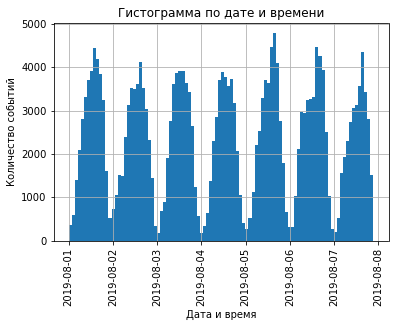

In [24]:
#Проверка правильности фильтрации
logs_filtered['datetime'].hist(bins=100)
plt.xlabel('Дата и время')
plt.ylabel('Количество событий')
plt.xticks(rotation = 90) # поворот надписей оси Х на 90 градусов
plt.title("Гистограмма по дате и времени")
plt.show()

In [65]:
# Рассчет количества событий и пользователей до удаления значений
events_before = len(logs)
users_before = len(logs_filtered['deviceidhash'].unique())

# Рассчет количества событий и пользователей после удаления значений
events_after = len(logs_filtered)
users_after = len(logs['deviceidhash'].unique())

# Рассчет потерянных событий и пользователей в абсолютных значениях
events_lost = events_before - events_after
users_lost = users_after - users_before 

# Рассчет потерянных событий и пользователей в относительных значениях
events_lost_percent = events_lost / events_before * 100
users_lost_percent = users_lost / users_before * 100

# Вывод результатов
print(f'Потеряно {events_lost} событий ({events_lost_percent:.2f}%)')
print(f'Потеряно {users_lost} пользователей ({users_lost_percent:.2f}%)')

Потеряно 2826 событий (1.16%)
Потеряно 17 пользователей (0.23%)


In [27]:
logs_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240887 entries, 2826 to 243712
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   eventname       240887 non-null  object        
 1   deviceidhash    240887 non-null  int64         
 2   eventtimestamp  240887 non-null  datetime64[ns]
 3   expid           240887 non-null  int64         
 4   datetime        240887 non-null  datetime64[ns]
 5   date            240887 non-null  datetime64[ns]
dtypes: datetime64[ns](3), int64(2), object(1)
memory usage: 12.9+ MB


**Выводы**:

- Мы нашли количество событий в логе, количество уникальных пользователей. 
- Определили максимальную и минимальную даты.
- Отбросили данные до 1 августа.
- Потеряли 17 пользователей, что составляет меньше 1%.
- При этом объем используемой памяти вырос с 11,2+ МБ до 12.9+ MБ

## 4. Изучение воронки событий.

- Какие события есть в логах, как часто они встречаются.
- Сколько пользователей совершали каждое из этих событий? Какая доля пользователей хоть раз совершала событие?
- Какой порядок  событий? Все ли они выстраиваются в последовательную цепочку?
- По воронке событий определить, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитайте отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.
- На каком шаге теряете больше всего пользователей?
- Какая доля пользователей доходит от первого события до оплаты?

### 4.1. Какие события есть в логах, как часто они встречаются?

### 4.1.1. Описание данных

Каждая запись в логе — это действие пользователя, или событие.

- _eventname_ — название события;
- _deviceidhash_ — уникальный идентификатор пользователя;
- _eventtimestamp_ — время события;
- _expid_ — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная;
- _datetime_ - дата в время событий;
- _date_ - дата события.

In [28]:
# Подсчет количества каждого события
event_counts = logs_filtered['eventname'].value_counts().sort_values(ascending=False)

# Вывод результата
event_counts

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: eventname, dtype: int64

**Вывод:**


- MainScreenAppear           _117328 главный экран_
- OffersScreenAppear          _46333 экран предложений_ 
- CartScreenAppear            _42303 экран корзины_
- PaymentScreenSuccessful     _33918 экран оплаты прошел успешно_ 
- Tutorial                     _1005 Учебное пособие_




- Видно, что количество каждого события уменьшается от шага к шагу. Посчитаем, сколько пользователей совершали каждое из этих событий.

### 4.2. Подсчет пользователей, которые совершали каждое из этих событий.

In [29]:
# Подсчет количества уникальных пользователей для каждого события
users_per_event = logs_filtered.groupby('eventname')['deviceidhash'].nunique().sort_values(ascending=False)

# Вывод результата
users_per_event

eventname
MainScreenAppear           7419
OffersScreenAppear         4593
CartScreenAppear           3734
PaymentScreenSuccessful    3539
Tutorial                    840
Name: deviceidhash, dtype: int64

In [30]:
# Подсчет доли пользователей, которые хоть раз совершали событие
total_users = logs_filtered['deviceidhash'].nunique()
user_ratio_per_event = (users_per_event / total_users * 100).round (2)

# Вывод результата
user_ratio_per_event

eventname
MainScreenAppear           98.47
OffersScreenAppear         60.96
CartScreenAppear           49.56
PaymentScreenSuccessful    46.97
Tutorial                   11.15
Name: deviceidhash, dtype: float64

### 4.3. Порядок событий.

Главный экран ``>>>`` экран предложений ``>>>`` экран корзины ``>>>`` экран успешной оплаты ``>>>`` обучение

- Складывается впечатление, что какое-то звено цепочки пропущено. Может быть авторизация.

In [31]:
logs_filtered['eventname'].head()

2826              Tutorial
2827      MainScreenAppear
2828      MainScreenAppear
2829    OffersScreenAppear
2830      MainScreenAppear
Name: eventname, dtype: object

In [58]:
users_count = logs_filtered.groupby('eventname')\
.agg({'deviceidhash': 'nunique'}).sort_values(by='deviceidhash', ascending=False)


users_count

,deviceidhash
eventname,
MainScreenAppear,7419
OffersScreenAppear,4593
CartScreenAppear,3734
PaymentScreenSuccessful,3539
Tutorial,840


In [33]:
# Подсчет количества уникальных пользователей для каждого события
users_per_event = logs_filtered.groupby('eventname')['deviceidhash'].nunique()
# Расчет долей пользователей, переходящих с одного шага воронки на следующий
# Подсчет количества пользователей на каждом шаге воронки
funnel = {
    #'MainScreenAppear': users_per_event['MainScreenAppear'],
    'MainScreenAppear > OffersScreenAppear': users_per_event['OffersScreenAppear'] / users_per_event['MainScreenAppear'] * 100,
    'OffersScreenAppear > CartScreenAppear': users_per_event['CartScreenAppear'] / users_per_event['OffersScreenAppear'] * 100,
    'CartScreenAppear > PaymentScreenSuccessful': users_per_event['PaymentScreenSuccessful'] / users_per_event['CartScreenAppear'] * 100,
    'PaymentScreenSuccessful > Tutorial': users_per_event['Tutorial'] / users_per_event['PaymentScreenSuccessful'] * 100
     }

# Вывод результата
pd.DataFrame.from_dict(funnel, orient='index', columns=['conversion, %'])

,"conversion, %"
MainScreenAppear > OffersScreenAppear,61.908613
OffersScreenAppear > CartScreenAppear,81.297627
CartScreenAppear > PaymentScreenSuccessful,94.777718
PaymentScreenSuccessful > Tutorial,23.735519


**Вывод:** 

- Здесь получился верный результат, но расчеты следует оптимизировать.

In [34]:
# Создание списка событий без Tutorial
event_list = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']

# Группировка данных по столбцу eventname
grouped = logs_filtered.groupby('eventname')

# Подсчет количества уникальных пользователей для каждого события
event_counts = grouped.agg({'deviceidhash': 'nunique'})

# Смещение shift()
event_counts_shifted = event_counts['deviceidhash'].shift(0)

# Создание словаря для хранения результатов
conversion_dict = {}

# Обход списка событий и рассчет конверсии для каждого события
for i in range(1, len(event_list)):
    event_name = event_list[i]
    prev_event_name = event_list[i-1]
    event_users = event_counts.loc[event_name, 'deviceidhash']
    prev_event_users = event_counts_shifted.loc[prev_event_name]
    conversion = event_users / prev_event_users * 100
    conversion_dict[event_name] = conversion

# Вывод результатов
for event_name, conversion in conversion_dict.items():
    print(f'Конверсия события {event_name}: {conversion:.2f}%')

Конверсия события OffersScreenAppear: 61.91%
Конверсия события CartScreenAppear: 81.30%
Конверсия события PaymentScreenSuccessful: 94.78%


In [35]:
# Подсчет количества уникальных пользователей для каждого события
users_per_event = logs_filtered.groupby('eventname')['deviceidhash'].nunique()
# Доля пользователей от первого события до оплаты
funnel = {
     'MainScreenAppear > PaymentScreenSuccessful': users_per_event['PaymentScreenSuccessful'] / users_per_event['MainScreenAppear'] * 100
}

# Вывод результата
pd.DataFrame.from_dict(funnel, orient='index', columns=['сonversion, %'])

,"сonversion, %"
MainScreenAppear > PaymentScreenSuccessful,47.701847


**Выводы**:

- Теперь видно, сколько человек дошли до каждого этапа продуктовой воронки. Примерно 62% зашедших на сайт пользователей перешли на экран предложений. Из них, 81 % перешли на экран корзины, далее на экран успешной оплаты дошло 94 %, а до обучения дошло лишь 23% с прошлого шага.
- На первом шаге с главного экрана потерялось 38 % пользователей, если брать тех, кто зашел в приложение по продуктам питания как 100%.
- Из расчетов убрали `Tutorial` навряд ли пользователям, которые заказывают продукты питания проходить обучение в мобильном приложении. Так же, возможно обучение можно проходить на разных шагах, а не обязательно после оплаты.
- От первого события до оплаты доходит меньше половины пользователей - 47 %.

## 5. Изучение результатов эксперимента.

- Сколько пользователей в каждой экспериментальной группе?
- Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверьте, находят ли статистические критерии разницу между выборками 246 и 247.
- Выберите самое популярное событие. Посчитайте число пользователей, совершивших это событие в каждой из контрольных групп. Посчитайте долю пользователей, совершивших это событие. Проверьте, будет ли отличие между группами статистически достоверным. Проделайте то же самое для всех других событий (удобно обернуть проверку в отдельную функцию). Можно ли сказать, что разбиение на группы работает корректно?
- Аналогично поступите с группой с изменённым шрифтом. Сравните результаты с каждой из контрольных групп в отдельности по каждому событию. Сравните результаты с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?
- Какой уровень значимости вы выбрали при проверке статистических гипотез выше? Посчитайте, сколько проверок статистических гипотез вы сделали. При уровне значимости 0.1 каждый десятый раз можно получать ложный результат. Какой уровень значимости стоит применить? Если вы хотите изменить его, проделайте предыдущие пункты и проверьте свои выводы.

### 5.1. Описание данных

Каждая запись в логе — это действие пользователя, или событие.

- _eventname_ — название события;
- _deviceidhash_ — уникальный идентификатор пользователя;
- _eventtimestamp_ — время события;
- _expid_ — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная;
- _datetime_ - дата в время событий;
- _date_ - дата события.

### 5.2. Количество пользователей в каждой экспериментальной группе.

In [36]:
# Подсчет количества уникальных пользователей в каждой экспериментальной группе
users_per_exp = logs_filtered.groupby('expid')['deviceidhash'].nunique()

# Вывод результата
users_per_exp

expid
246    2484
247    2513
248    2537
Name: deviceidhash, dtype: int64

In [64]:
# Создание сводной таблицы без Tutorial
pivot_table = logs_filtered[logs_filtered['eventname'] != 'Tutorial'].pivot_table(index='expid',
                                                                                  columns='eventname',
                                                                                  values='deviceidhash',
                                                                                  aggfunc='nunique')

# Вывод транспонированной таблицы
pivot_table.T

expid,246,247,248
eventname,,,
CartScreenAppear,1266,1238,1230
MainScreenAppear,2450,2476,2493
OffersScreenAppear,1542,1520,1531
PaymentScreenSuccessful,1200,1158,1181


In [41]:
# Создание датафрейма
group_count = logs_filtered.pivot_table(index = 'expid', columns = 'eventname', values = 'deviceidhash', aggfunc = 'nunique')
# добавление в датайфрейм столбца с общим кол-ом пользователей по группе
group_count['Total'] = logs_filtered.groupby('expid')['deviceidhash'].nunique()
# group_count['sum_246_247'] = logs_filtered.query('logs_filtered["'expid'== '246', '247'")['event'].sum()
group_count

eventname,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial,Total
expid,,,,,,
246,1266,2450,1542,1200,278,2484
247,1238,2476,1520,1158,283,2513
248,1230,2493,1531,1181,279,2537


In [42]:
#В z тесте P-это доли, которые считаются по переменным sussesses и trials
# Первая переменная это фильтр лога по группе, шагу воронки и подсчету уникальных пользователей (сделано выше).
# Вторая переменная фильтр только по группе.
# sussesses - колич. пользователей в событии.
# trials - колич. событий всего.
# Функция для проведения теста с использованием z-критерия:
def proverka(successes1, successes2, trials1, trials2, alpha=0.05): #задаем
    # пропорция успехов в первой группе:
    p1 = successes1/trials1
 
    # пропорция успехов во второй группе:
    p2 = successes2/trials2
 
    # пропорция успехов в комбинированном датасете:
    p_combined = (successes1 + successes2) / (trials1 + trials2)
 
    # разница пропорций в датасетах
    difference = p1 - p2
    
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / np.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))
 
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = stats.norm(0, 1) 
 
    p_value = (1 - distr.cdf(abs(z_value))) * 2
 
    print('p-значение: ', p_value)
    print('уровень значимости: ', alpha)
 
    if (p_value < alpha): print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
    else: print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")  
        
    print()

In [43]:
с_246 = group_count.iloc[0,0] #CartScreenAppear 246
с_247 = group_count.iloc[1,0] #CartScreenAppear 247
с_248 = group_count.iloc[2,0] #CartScreenAppear 248

t_246 = group_count.iloc[0,5] #CartScreenAppear 246
t_247 = group_count.iloc[1,5] #CartScreenAppear 247
t_248 = group_count.iloc[2,5] #CartScreenAppear 248

proverka(с_246,с_247,t_246,t_247) # А/А (246, 247)
proverka (с_247,с_248,t_247,t_248) # А/А (247, 248)
proverka(с_246,с_248,t_246,t_248) # А/В (246, 248)
proverka(с_246 + с_247, с_248, group_count.iloc[0,5]+ t_247, t_248) # 246+247/248

p-значение:  0.22883372237997213
уровень значимости:  0.05
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

p-значение:  0.5786197879539783
уровень значимости:  0.05
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

p-значение:  0.07842923237520116
уровень значимости:  0.05
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

p-значение:  0.18175875284404386
уровень значимости:  0.05
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [44]:
m_246 = group_count.iloc[0,1] #MainScreenAppear 246
m_247 = group_count.iloc[1,1] #MainScreenAppear 247
m_248 = group_count.iloc[2,1] #MainScreenAppear 248

mt_246 = group_count.iloc[0,5] # Total 246
mt_247 = group_count.iloc[1,5] # Total 247
mt_248 = group_count.iloc[2,5] # Total 248

proverka(m_246 ,m_247,mt_246,mt_247) # А/А (246, 247)
proverka (m_247,m_248,mt_247,mt_248) # А/А (247, 248)
proverka(m_246,m_248,mt_246,mt_248) # А/В (246, 248)
proverka(m_246 + m_247, m_248, mt_246 + mt_247, mt_248) # 246+247/248

p-значение:  0.7570597232046099
уровень значимости:  0.05
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

p-значение:  0.4587053616621515
уровень значимости:  0.05
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

p-значение:  0.2949721933554552
уровень значимости:  0.05
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

p-значение:  0.29424526837179577
уровень значимости:  0.05
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [45]:
o_246 = group_count.iloc[0,2] #OffersScreenAppear 246
o_247 = group_count.iloc[1,2] #OffersScreenAppear 247
o_248 = group_count.iloc[2,2] #OffersScreenAppear 248


ot_246 = group_count.iloc[0,5] # Total 246
ot_247 = group_count.iloc[1,5] # Total 247  
ot_248 = group_count.iloc[2,5] # Total 248 

proverka(o_246 ,o_247,ot_246,ot_247) # А/А (246, 247)
proverka (o_247,o_248,ot_247,ot_248) # А/B (247, 248)
proverka(o_246,o_248,ot_246,ot_248) # А/В (246, 248)
proverka(o_246 + o_247, o_248, ot_246 + ot_247, ot_248) # 246+247/248

p-значение:  0.2480954578522181
уровень значимости:  0.05
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

p-значение:  0.9197817830592261
уровень значимости:  0.05
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

p-значение:  0.20836205402738917
уровень значимости:  0.05
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

p-значение:  0.43425549655188256
уровень значимости:  0.05
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [46]:
p_246 = group_count.iloc[0,3] #PaymentScreenSuccessful 246
p_247 = group_count.iloc[1,3] #PaymentScreenSuccessful 247
p_248 = group_count.iloc[2,3] #PaymentScreenSuccessful 248


pt_246 = group_count.iloc[0,5] # Total 246
pt_247 = group_count.iloc[1,5] # Total 247
pt_248 = group_count.iloc[2,5] # Total 248

proverka(p_246 ,p_247,pt_246,pt_247) # А/А (246, 247)
proverka (p_247,p_248,pt_247,pt_248) # А/B (247, 248)
proverka(p_246,p_248,pt_246,pt_248) # А/В (246, 248)
proverka(p_246 + p_247, p_248, pt_246 + pt_247, pt_248) # 246+247/248

p-значение:  0.11456679313141849
уровень значимости:  0.05
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

p-значение:  0.7373415053803964
уровень значимости:  0.05
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

p-значение:  0.2122553275697796
уровень значимости:  0.05
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

p-значение:  0.6004294282308704
уровень значимости:  0.05
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



# Вывод

- В данном исследования мы проанализировали поведение покупателей на основании логов пользователей, результаты А/А/В-теста. После предобработки данных было рассмотрено поведение 7419-ти пользователей мобильного приложения.

**Было выявлено, что**:

- В каждой экспериментальной группе было `246 - 2484 наблюдений`, `247 - 2513 наблюдений`, `248- 2537 наблюдений`.
- Для того, чтобы проверить корректность всех механизмов и расчётов для А/А-эксперимента. Мы установили, статистические критерии и разницу между выборками 246 и 247 не нашли.
- Самое популярное событие это регистрация, после неё до следующего шага доходят  61.91%. 
- Конверсия события на следующий шаг 81.30%. 
- Конверсия события PaymentScreenSuccessful: 94.78%. При этом от первого события до оплаты доходит меньше половины пользователей - 47,7 %.


**Потеря пользователей**:

- Больше всего пользователей терялось после первого шага (> 38%)
- Чуть менее 9%  просмотрели товар.
- Из них потерялись на следующем шаге и около 2%.
- То есть примерно 48% пользователей воспользовались приложением и оплатили заказ.


**Анализ результата А/А/В-эксперимента(изменение шрифта во всем приложении)**:

- Для этого были ипользованы логи событий за неделю (с 01/08/2019 по 07/08/2019).
- Были учтено поведение пользователей, разделенных на три группы:

` 246-ая - 2484 пользователя;`
`247-ая - 2513 пользователя;`
`248-ая - 2537 пользователя.`

- Нам нужно было сопоставить доли пользователей по каждому событию между:

`контрольными группами 246 и 247;`
`каждой из контрольной группы по отдельности и экспериментальной (246-248 и 247-248);`
`объединенной контрольной группой и экспериментальной (246+247 и 248).`


**Итоговый вывод**:
- После проведенного исследования видно, что разбиение на группы работает корректно.
- При сравнении результатов с объединённой контрольной группой видно, что изменение шрифта не привлекло бОльшее количество клиентов. Возможно, дизайнерам нужно что-то ещё изменить.
- При проверке статистических гипотез выше был взят уровень значимости:  0.05. Было сделано 4 по 4 проверки статистических гипотез. При уровне значимости 0.1 каждый десятый раз можно получать ложный результат.